### how to use this notebook
a) is for my traditional ML approach(es)  
b) is for my DL one    

---

1 simply loads shit into raw objects  
2 compare raw object - does visualization and analysis  
3 loads raw objects into features (inside you will find some visualizations on the features)
- must create X_train, y_train, X_val, y_val, X_test, y_test, (X_own, y_own)  

4 are the abstraction functions for the models - must create model object of MyModel class that has following functions
```python
class MyModel():
    def __init__(self):
        pass

    def load(self):
        pass

    def save(self):
        pass

    def predict(self, X, y):
        pass

    def train(self, X, y):
        pass

    def finetune(self, X, y):
        pass

    def evaluate(self, X, y):
        pass
```

5 uses abstractions for training  
6 uses abstraction for finetuning  
7 does inferences and model export  

### setup (always run)

In [1]:
experiment_name = "02_stat" # input("name your experiment (or use old one) > ")  # like lstm_00

In [2]:
import os
from google.colab import drive
from IPython.display import clear_output as cls

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
sfreq = 128
channels = ['F7','F3','P7','O1','O2','P8','AF4']
seed = 42

In [4]:
BASE_PATH = "/content/drive/MyDrive/datasets/FOCUS"
IO_PATH = f'{BASE_PATH}/io/{experiment_name}/' # not-existant or populated - ! NOT EMPTY !
MODEL_SAVE_PATH = f'{BASE_PATH}/model/{experiment_name}/' # is going to be created if it doesn't exist yet
DATA_FOLDER_PATH = f'{BASE_PATH}/dataset/' # has to exist

if not os.path.exists(MODEL_SAVE_PATH):
    print(f"model folder not existing, creating at {MODEL_SAVE_PATH}")
    os.mkdir(MODEL_SAVE_PATH)
else:
    print(f"ATTENTION: model folder already exists, only proceed if you are ready to overwrite")

if not os.path.exists(DATA_FOLDER_PATH):
    raise Exception("make sure dataset exists")

ATTENTION: model folder already exists, only proceed if you are ready to overwrite


In [5]:
!pip install mne scipy mne-icalabel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.6/21.6 MB 31.7 MB/s eta 0:00:00


In [6]:
import mne

def construct_mne_raw(eeg_data, channels, sfreq):
    """
    simply copies, what we did in process_dataset
    expects shape of (n_channels, n_timesteps)
    """
    info = mne.create_info(
        ch_names=channels,
        sfreq=sfreq,
        ch_types=['eeg'] * len(channels)
    )

    raw = mne.io.RawArray(eeg_data, info)
    return raw

In [7]:
print(sfreq)

128


### 1. loading dataset from scratch into RAW objects

In [8]:
from typing import List, Dict

import mne
import scipy.io as scio


def load_dataset(dataset_path: str, sfreq:float, useful_channels:list) -> tuple:
    """
    https://www.sciencedirect.com/science/article/abs/pii/S0957417419303926
    https://www.kaggle.com/datasets/inancigdem/eeg-data-for-mental-attention-state-detection?select=EEG+Data

    folder has `.mat` files with n_samples x len(columns size)

    columns = [
        'ED_COUNTER',    'ED_INTERPOLATED',    'ED_RAW_CQ',
        'ED_AF3',    'ED_F7', 'ED_F3',    'ED_FC5',    'ED_T7',    'ED_P7',    'ED_O1', 'ED_O2',    'ED_P8',    'ED_T8',    'ED_FC6',    'ED_F4', 'ED_F8',    'ED_AF4',
        'ED_GYROX',    'ED_GYROY',    'ED_TIMESTAMP', 'ED_ES_TIMESTAMP',    'ED_FUNC_ID',    'ED_FUNC_VALUE',    'ED_MARKER',    'ED_SYNC_SIGNAL'
    ]

    => we remove all but the second row

    each file is a single recording. each subject has 4-5 recordings (see subject_map for mapping)
    """
    raw_list = []
    info_list = []

    mkpt1 = int(sfreq*10*60)   # 0-10min are "focused"
    mkpt2 = int(sfreq*20*60)   # 10-20min are "unfocused"
    mkpt3 = int(sfreq*30*60)   # rest is "drowsy" - BUT we don't need that many labels of it (I think)


    # these are the present channels, the useful_channels array we take has to to have times that include this one here
    channels = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
    use_channel_inds = []
    for c in useful_channels:
        if c in channels:
            use_channel_inds.append(channels.index(c))
        else:
            raise KeyError("channel {c} does not exist in dataset")

    n_subjects = 5
    subject_map = {1: [3, 4, 5, 6, 7], 2: [10, 11, 12, 13, 14], 3: [17, 18, 19, 20, 21], 4: [24, 25, 26, 27, 28], 5: [31, 32, 33, 34]}

    # get each subject
    for subject_id in range(1, n_subjects+1):

        # get each recording for one of the subjects
        for i, trial_id in enumerate(subject_map[subject_id]):
            trial_data = scio.loadmat(dataset_path + f'eeg_record{trial_id}.mat')
            trial_data = trial_data['o']['data'][0][0][:, 3:17][:, use_channel_inds]
            trial_data = [trial_data[:mkpt1], trial_data[mkpt1:mkpt2], trial_data[mkpt2:mkpt3]]


            for eeg_data, label in zip(trial_data, ["focused", "unfocused", "drowsy"]):

                # eeg_data is first in shape (n_timesteps, n_channels), has to be transformed
                raw = construct_mne_raw(eeg_data.T, useful_channels, sfreq)

                metadata = {
                    'subject_id': subject_id,
                    'trial_id': trial_id,
                    'label': 0 if label == "focused" else 1 if label == "unfocused" else 2,
                    'label_text': label,
                }

                raw_list.append(raw)
                info_list.append(metadata)

    return raw_list, info_list


# ---
raw_list, info_list = load_dataset(DATA_FOLDER_PATH, sfreq, channels)
cls()
print(f"\n\nLoaded {len(raw_list)} recordings, from {len(set([info['subject_id'] for info in info_list]))} subjects")


# takes 1 min
# RAM: 9.4gb - 2.2



Loaded 72 recordings, from 5 subjects


### 1. loading custom collected data (extra-device, extra-subject)

In [9]:
import numpy as np

# we expect 128Hz
focused_buffer = np.load(IO_PATH+"focused.npy")
unfocused_buffer = np.load(IO_PATH+"unfocused.npy")

focused_object = construct_mne_raw(focused_buffer, channels, sfreq)
focused_info = {"subject_id": 999, "trial_id": 999, "label": 0, "label_text": "focused"}
unfocused_object = construct_mne_raw(unfocused_buffer, channels, sfreq)
unfocused_info = {"subject_id": 999, "trial_id": 999, "label": 1, "label_text": "unfocused"}

# we assume that the data that is in that file follows the channels that we set here as the ones used


cls()
print(focused_buffer.shape)

(7, 5120)


### 2. fancy graphs for testing and comparing raw objects

In [10]:
def get_subset(raw:mne.io.Raw, n_seconds=5):
    """
    returns the same raw object but only with the last n_seconds seconds, if shorter, will throw a warning and return the exact same
    - has to have sfreq set in the info object
    """

    sfreq = raw.info['sfreq']
    n_samples = int(n_seconds * sfreq)
    total_samples = raw.n_times

    if total_samples <= n_samples:
        print(f"Warning: Raw object contains only {total_samples/sfreq:.2f} seconds, which is less than {n_seconds} seconds.")
        return raw.copy()

    start_sample = total_samples - n_samples
    raw_last_5s = raw.copy().crop(tmin=start_sample/sfreq)
    return raw_last_5s


# - must all be focused
raw_own = focused_object
info_own = focused_info

raw = get_subset(raw_list[0])
info = info_list[0]
print(info)

raw_extra = get_subset(raw_list[66])
info_extra = info_list[66]
print(info_extra)


def get_channel_locations_from_mne(raw):
    """
    make sure montage is set
    """

    pos_3d = raw.get_montage().get_positions()['ch_pos']
    ch_names = raw.ch_names

    location_dict = {}
    for ch in ch_names:
        if ch in pos_3d:
            x, y, _ = pos_3d[ch]
            location_dict[ch] = (x, y)

    return location_dict


montage = mne.channels.make_standard_montage("standard_1020")
raw.set_montage(montage)
raw_own.set_montage(montage)
raw_extra.set_montage(montage)
# fig_topo = raw.plot_sensors(show_names=True)

STEW_CHANNEL_LOCATION_DICT = get_channel_locations_from_mne(raw)
CHANNEL_NAMES = list(STEW_CHANNEL_LOCATION_DICT.keys())
print(STEW_CHANNEL_LOCATION_DICT)

{'subject_id': 1, 'trial_id': 3, 'label': 0, 'label_text': 'focused'}
{'subject_id': 5, 'trial_id': 33, 'label': 0, 'label_text': 'focused'}
{'F7': (np.float64(-0.07187662505917264), np.float64(0.07310352742670875)), 'F3': (np.float64(-0.05180903841183724), np.float64(0.08668789888287941)), 'P7': (np.float64(-0.07445796452347851), np.float64(-0.04212316495850575)), 'O1': (np.float64(-0.03157355787465608), np.float64(-0.08056835212663661)), 'O2': (np.float64(0.027683100559624117), np.float64(-0.08048883980936473)), 'P8': (np.float64(0.07103247088902218), np.float64(-0.042259976012095204)), 'AF4': (np.float64(0.0342298581732583), np.float64(0.10981127208682755))}


Using matplotlib as 2D backend.


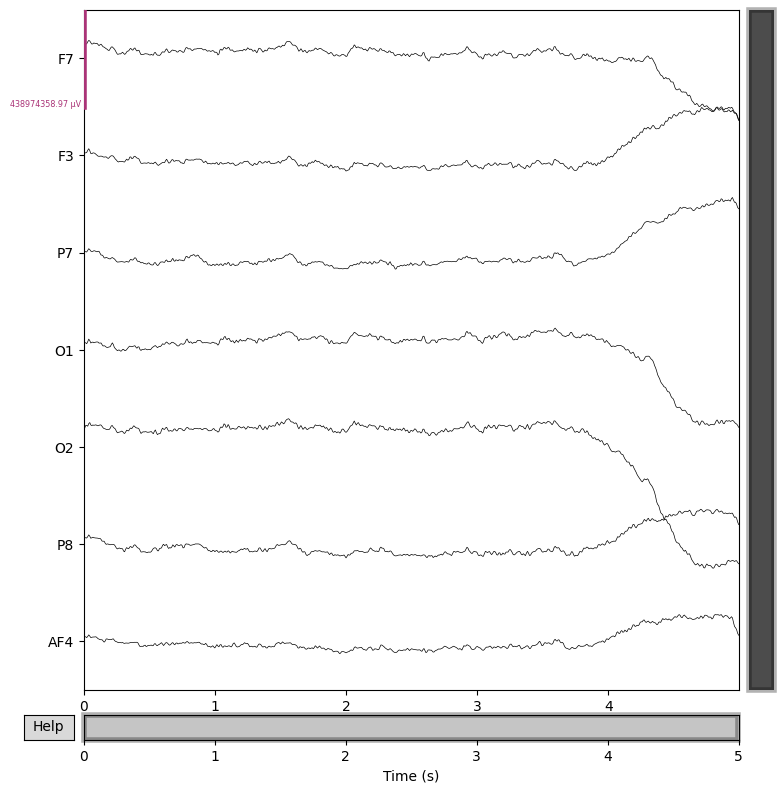

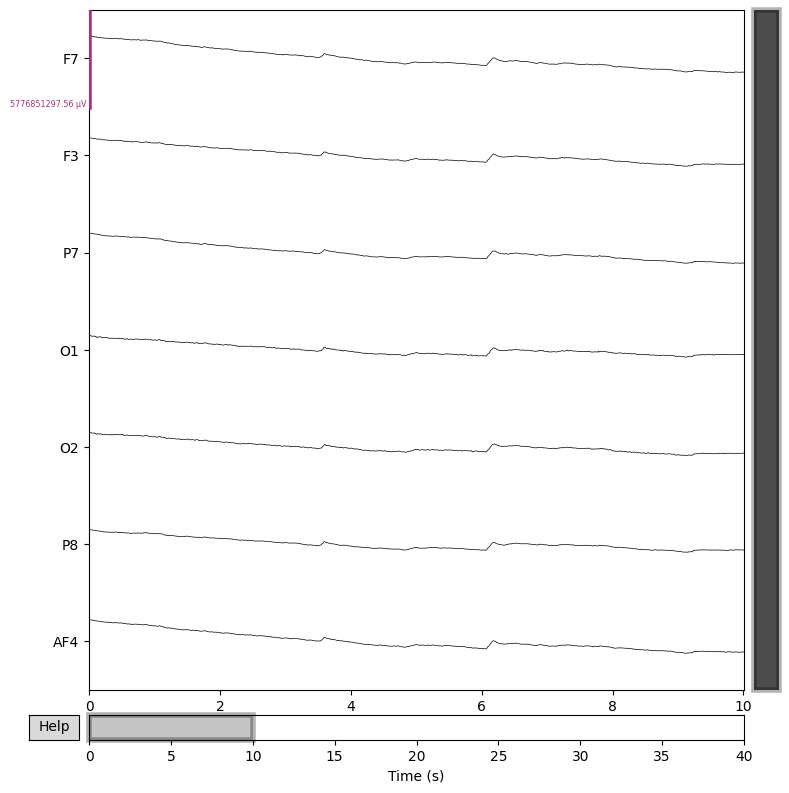

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 5.000 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).


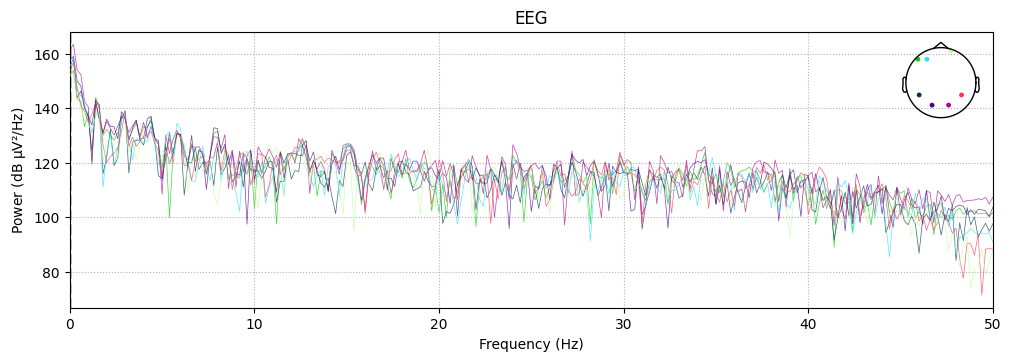

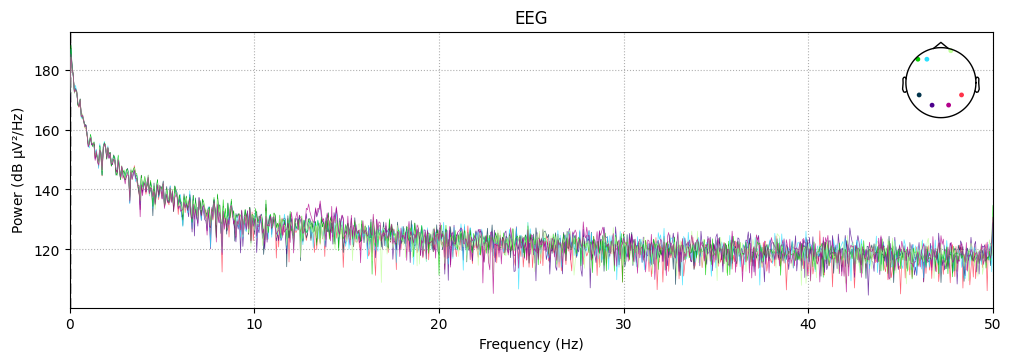

In [11]:
import matplotlib.pyplot as plt

# plot raw graph
fig = raw.plot(duration=10, n_channels=20, scalings='auto', title='Raw Data')
fig = raw_own.plot(duration=10, n_channels=20, scalings='auto', title='Raw Data')

# plot power spectral density
fig_psd = raw.plot_psd(fmax=50)
fig_psd = raw_own.plot_psd(fmax=50)

Analyzing 7 common channels
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).

=== Device Difference Analysis ===
Max PCA angle difference: 81.71° (Threshold: 45°)
Max frequency band difference: 11.08 dB (Threshold: 10 dB)
Mean SNR difference: 5.75 dB (Threshold: 6 dB)
Mean channel correlation: -0.07 (Threshold: 0.5)

Thresholds exceeded:
- PCA angles > 45°: Yes
- Frequency diff > 10dB: Yes
- SNR diff > 6dB: No
- Correlation < 0.5: Yes


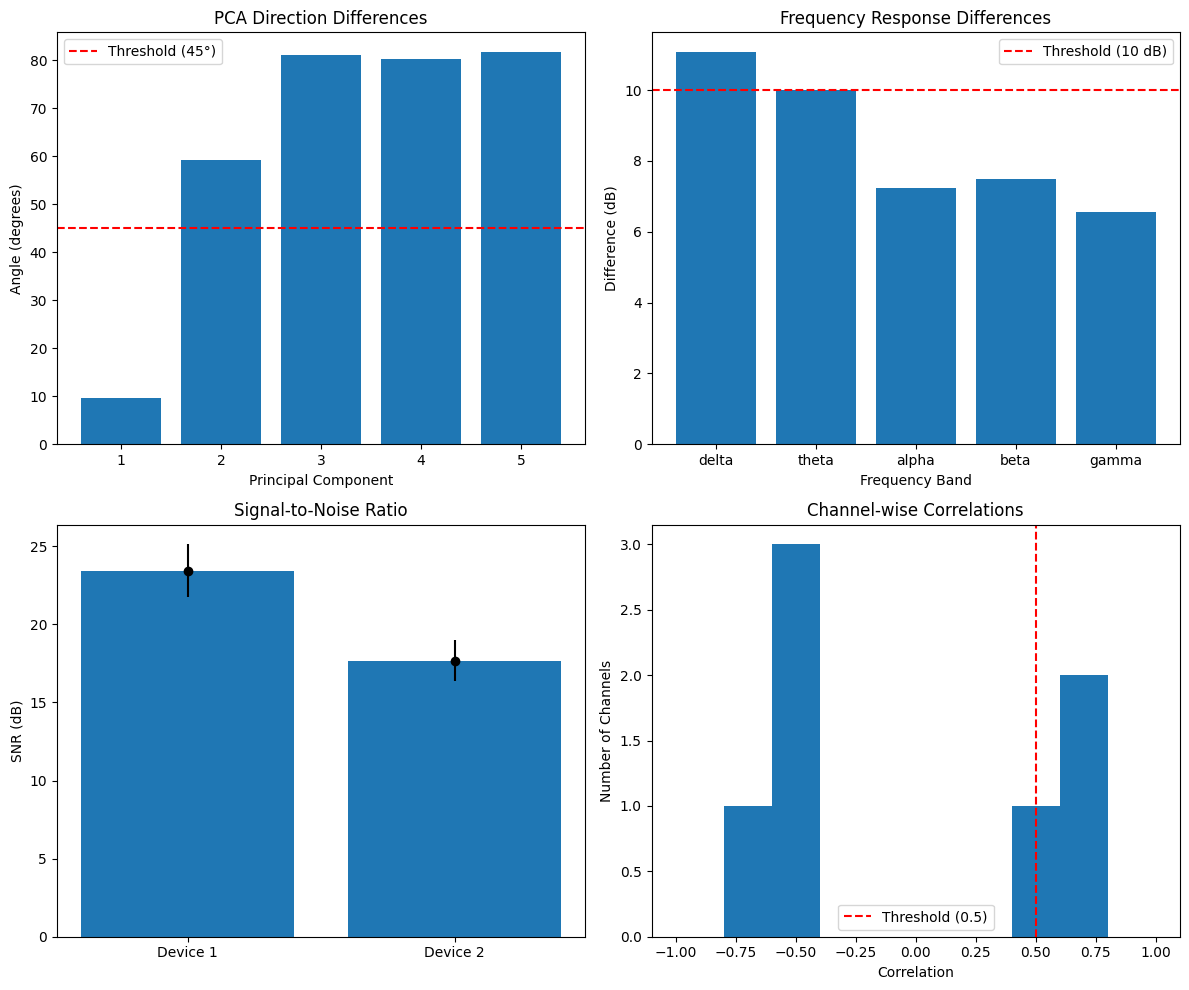

{'pc_angles': [np.float64(9.5852914845032), np.float64(59.216288973546526), np.float64(81.08919408091826), np.float64(80.18690915654463), np.float64(81.7067824156306)], 'max_pc_angle': np.float64(81.7067824156306), 'pc_angle_threshold_exceeded': True, 'freq_diffs': {'delta': np.float64(11.078615577274267), 'theta': np.float64(10.015452229405899), 'alpha': np.float64(7.229638309130067), 'beta': np.float64(7.4998568811530015), 'gamma': np.float64(6.55446073105549)}, 'max_freq_diff': np.float64(11.078615577274267), 'freq_diff_threshold_exceeded': True, 'snr_diff': np.float64(5.745411973429879), 'snr_diff_threshold_exceeded': np.False_, 'channel_correlations': [np.float64(0.5174821934115434), np.float64(0.6500848000309216), np.float64(0.6108684043767596), np.float64(-0.5369581308241405), np.float64(-0.605736676801786), np.float64(-0.5830813806168755), np.float64(-0.5362693441018928)], 'mean_correlation': np.float64(-0.06908716207506715), 'correlation_threshold_exceeded': np.True_}
Analyzin

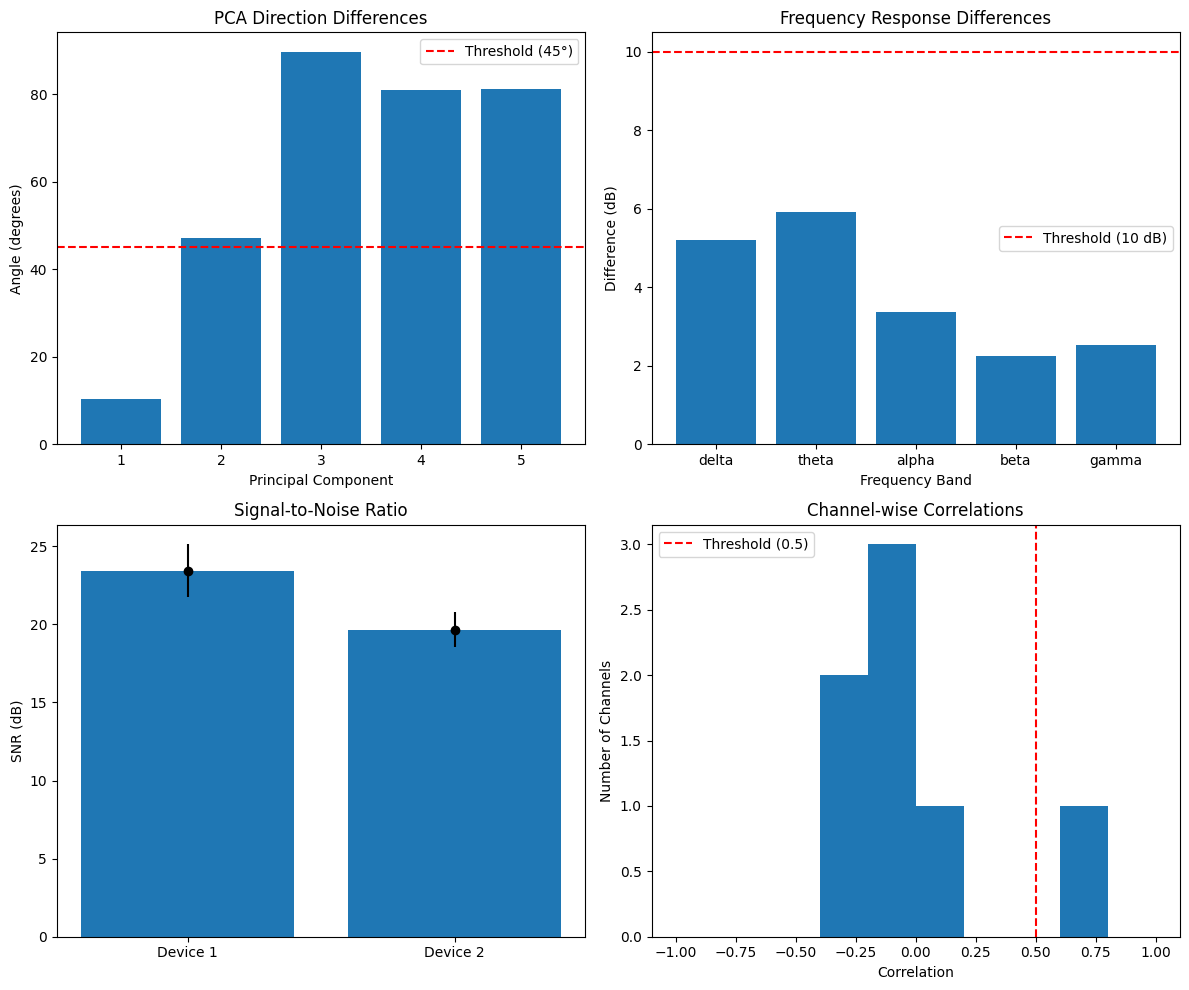

{'pc_angles': [np.float64(10.302263835771356), np.float64(47.257665669178394), np.float64(89.68499304782738), np.float64(81.08018648157575), np.float64(81.27457518364528)], 'max_pc_angle': np.float64(89.68499304782738), 'pc_angle_threshold_exceeded': True, 'freq_diffs': {'delta': np.float64(5.194835081461662), 'theta': np.float64(5.929953159355726), 'alpha': np.float64(3.3687161672932144), 'beta': np.float64(2.258879296017911), 'gamma': np.float64(2.522722174410055)}, 'max_freq_diff': np.float64(5.929953159355726), 'freq_diff_threshold_exceeded': False, 'snr_diff': np.float64(3.757854768190833), 'snr_diff_threshold_exceeded': np.False_, 'channel_correlations': [np.float64(0.09993751323945385), np.float64(-0.0766673134211382), np.float64(-0.38761641561941523), np.float64(0.6298396173728839), np.float64(-0.0915876695571864), np.float64(-0.22362301351452632), np.float64(-0.06187692286093889)], 'mean_correlation': np.float64(-0.01594202919440962), 'correlation_threshold_exceeded': np.True_

In [12]:
import mne
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import pearsonr

def compare_eeg_devices(raw1:mne.io.Raw, raw2:mne.io.Raw):
    freq_bands = {
        'delta': (1, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'beta': (13, 30),
        'gamma': (30, 45)
    }

    # only use common channels (which should be all if the same)
    common_channels = list(set(raw1.ch_names).intersection(set(raw2.ch_names)))

    print(f"Analyzing {len(common_channels)} common channels")

    # Pick common channels and get data
    data1 = raw1.copy().pick_channels(common_channels).get_data()
    data2 = raw2.copy().pick_channels(common_channels).get_data()

    # Ensure same sampling rate for frequency analysis
    sfreq1 = raw1.info['sfreq']
    sfreq2 = raw2.info['sfreq']

    if sfreq1 != sfreq2:
        print(f"Warning: Different sampling rates ({sfreq1} Hz vs {sfreq2} Hz)")
        # Use the lower sampling rate for analysis
        target_sfreq = min(sfreq1, sfreq2)
        if sfreq1 > target_sfreq:
            raw1_resampled = raw1.copy().resample(target_sfreq)
            data1 = raw1_resampled.pick_channels(common_channels).get_data()
        if sfreq2 > target_sfreq:
            raw2_resampled = raw2.copy().resample(target_sfreq)
            data2 = raw2_resampled.pick_channels(common_channels).get_data()
        sfreq = target_sfreq
    else:
        sfreq = sfreq1

    # Ensure same data length
    min_length = min(data1.shape[1], data2.shape[1])
    data1 = data1[:, :min_length]
    data2 = data2[:, :min_length]

    results = {}

    # 1. PCA direction differences
    pca1 = PCA(n_components=min(5, len(common_channels)))
    pca2 = PCA(n_components=min(5, len(common_channels)))

    pca1.fit(data1)
    pca2.fit(data2)

    pc_angles = []
    for i in range(min(pca1.components_.shape[0], pca2.components_.shape[0])):
        # Calculate angle between principal components
        cos_angle = np.abs(np.dot(pca1.components_[i], pca2.components_[i])) / (
            np.linalg.norm(pca1.components_[i]) * np.linalg.norm(pca2.components_[i])
        )
        angle_degrees = np.arccos(min(cos_angle, 1.0)) * 180 / np.pi
        pc_angles.append(angle_degrees)

    results['pc_angles'] = pc_angles
    results['max_pc_angle'] = max(pc_angles)
    results['pc_angle_threshold_exceeded'] = any(angle > 45 for angle in pc_angles)

    # 2. Frequency response differences
    freq_diffs = {}
    for band_name, (fmin, fmax) in freq_bands.items():
        # Compute power spectral density
        f1, psd1 = signal.welch(data1, fs=sfreq, nperseg=min(1024, min_length))
        f2, psd2 = signal.welch(data2, fs=sfreq, nperseg=min(1024, min_length))

        # Find indices for the frequency band
        idx1 = np.logical_and(f1 >= fmin, f1 <= fmax)
        idx2 = np.logical_and(f2 >= fmin, f2 <= fmax)

        # Calculate mean power in dB for each channel
        power1_db = 10 * np.log10(np.mean(psd1[:, idx1], axis=1))
        power2_db = 10 * np.log10(np.mean(psd2[:, idx2], axis=1))

        # Calculate difference
        diff_db = np.abs(power1_db - power2_db)
        max_diff_db = np.max(diff_db)
        freq_diffs[band_name] = max_diff_db

    results['freq_diffs'] = freq_diffs
    results['max_freq_diff'] = max(freq_diffs.values())
    results['freq_diff_threshold_exceeded'] = any(diff > 10 for diff in freq_diffs.values())

    # 3. SNR differences
    # Estimate SNR using variance of signal vs. high frequency noise
    def estimate_snr(data, sfreq):
        # Use high frequency band as noise estimate
        f, psd = signal.welch(data, fs=sfreq, nperseg=min(1024, data.shape[1]))
        signal_idx = np.logical_and(f >= 1, f <= 40)  # Main EEG bands
        noise_idx = f > 40  # Higher frequencies as noise estimate

        if not np.any(noise_idx):
            # If sampling rate is too low for noise estimate
            noise_idx = f > 30

        signal_power = np.mean(psd[:, signal_idx], axis=1)
        noise_power = np.mean(psd[:, noise_idx], axis=1) if np.any(noise_idx) else np.var(data, axis=1) * 0.1

        # Avoid division by zero
        noise_power = np.maximum(noise_power, 1e-10)

        snr_db = 10 * np.log10(signal_power / noise_power)
        return snr_db

    snr1 = estimate_snr(data1, sfreq)
    snr2 = estimate_snr(data2, sfreq)

    snr_diff = np.abs(snr1 - snr2)
    results['snr_diff'] = np.mean(snr_diff)
    results['snr_diff_threshold_exceeded'] = np.mean(snr_diff) > 6

    # 4. Channel-wise correlation
    correlations = []
    for ch_idx in range(len(common_channels)):
        corr, _ = pearsonr(data1[ch_idx], data2[ch_idx])
        correlations.append(corr)

    results['channel_correlations'] = correlations
    results['mean_correlation'] = np.mean(correlations)
    results['correlation_threshold_exceeded'] = np.mean(correlations) < 0.5

    # Summary
    print("\n=== Device Difference Analysis ===")
    print(f"Max PCA angle difference: {results['max_pc_angle']:.2f}° (Threshold: 45°)")
    print(f"Max frequency band difference: {results['max_freq_diff']:.2f} dB (Threshold: 10 dB)")
    print(f"Mean SNR difference: {results['snr_diff']:.2f} dB (Threshold: 6 dB)")
    print(f"Mean channel correlation: {results['mean_correlation']:.2f} (Threshold: 0.5)")

    print("\nThresholds exceeded:")
    print(f"- PCA angles > 45°: {'Yes' if results['pc_angle_threshold_exceeded'] else 'No'}")
    print(f"- Frequency diff > 10dB: {'Yes' if results['freq_diff_threshold_exceeded'] else 'No'}")
    print(f"- SNR diff > 6dB: {'Yes' if results['snr_diff_threshold_exceeded'] else 'No'}")
    print(f"- Correlation < 0.5: {'Yes' if results['correlation_threshold_exceeded'] else 'No'}")

    # Create visualization
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # Plot PCA angles
    axs[0, 0].bar(range(1, len(pc_angles)+1), pc_angles)
    axs[0, 0].axhline(y=45, color='r', linestyle='--', label='Threshold (45°)')
    axs[0, 0].set_xlabel('Principal Component')
    axs[0, 0].set_ylabel('Angle (degrees)')
    axs[0, 0].set_title('PCA Direction Differences')
    axs[0, 0].legend()

    # Plot frequency differences
    bands = list(freq_diffs.keys())
    diffs = list(freq_diffs.values())
    axs[0, 1].bar(bands, diffs)
    axs[0, 1].axhline(y=10, color='r', linestyle='--', label='Threshold (10 dB)')
    axs[0, 1].set_xlabel('Frequency Band')
    axs[0, 1].set_ylabel('Difference (dB)')
    axs[0, 1].set_title('Frequency Response Differences')
    axs[0, 1].legend()

    # Plot SNR
    axs[1, 0].bar(['Device 1', 'Device 2'], [np.mean(snr1), np.mean(snr2)])
    axs[1, 0].errorbar(['Device 1', 'Device 2'], [np.mean(snr1), np.mean(snr2)],
                      yerr=[np.std(snr1), np.std(snr2)], fmt='o', color='black')
    axs[1, 0].set_ylabel('SNR (dB)')
    axs[1, 0].set_title('Signal-to-Noise Ratio')

    # Plot correlations
    axs[1, 1].hist(correlations, bins=10, range=(-1, 1))
    axs[1, 1].axvline(x=0.5, color='r', linestyle='--', label='Threshold (0.5)')
    axs[1, 1].set_xlabel('Correlation')
    axs[1, 1].set_ylabel('Number of Channels')
    axs[1, 1].set_title('Channel-wise Correlations')
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()

    return results


results = compare_eeg_devices(raw, raw_own)
print(results)

results = compare_eeg_devices(raw, raw_extra)
print(results)

### 3a. time-binned vector features

In [13]:
### preprocessing function
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import windows
from mne.time_frequency import tfr_array_morlet


def process_eeg_sample(raw, sfreq, ch_names):
    """
    splits a raw object into its window size and does the feature engineering according to the paper to it
    https://www.sciencedirect.com/science/article/abs/pii/S0957417419303926
    """

    raw.filter(0.5, 45)
    raw.notch_filter(50)

    data = raw.get_data()
    times = raw.times

    window_length = 15
    step_size = 1

    window_samples = int(window_length * sfreq)
    step_samples = int(step_size * sfreq)

    blackman_window = windows.blackman(window_samples)

    n_windows = (data.shape[1] - window_samples) // step_samples + 1

    # Prepare for STFT
    n_channels = data.shape[0]
    n_fft = 1024

    # Initialize spectrogram array
    spectrograms = np.zeros((n_channels, n_windows, n_fft//2 + 1))

    # Calculate STFT for each channel
    for ch_idx in range(n_channels):
        for win_idx in range(n_windows):
            # Extract window
            start_idx = win_idx * step_samples
            end_idx = start_idx + window_samples
            window_data = data[ch_idx, start_idx:end_idx]

            # Apply Blackman window
            windowed_data = window_data * blackman_window

            # Calculate FFT
            fft_result = np.fft.rfft(windowed_data, n=n_fft)

            # Calculate power spectrum
            power_spectrum = np.abs(fft_result)**2

            # Store in spectrogram
            spectrograms[ch_idx, win_idx, :] = power_spectrum

    # Calculate frequency bins
    freqs = np.fft.rfftfreq(n_fft, d=1/sfreq)

    # Bin into 0.5 Hz bands (from 0 to 18 Hz)
    bin_size = 0.5
    max_freq = 18.0
    n_bins = int(max_freq / bin_size)

    binned_spectrograms = np.zeros((n_channels, n_windows, n_bins))

    # Fixed binning approach
    for ch_idx in range(n_channels):
        for win_idx in range(n_windows):
            for bin_idx in range(n_bins):
                freq_start = bin_idx * bin_size
                freq_end = (bin_idx + 1) * bin_size

                # Find indices of frequencies in this bin
                bin_indices = np.where((freqs >= freq_start) & (freqs < freq_end))[0]

                if len(bin_indices) > 0:
                    # Average power in this frequency bin
                    binned_spectrograms[ch_idx, win_idx, bin_idx] = np.mean(
                        spectrograms[ch_idx, win_idx, bin_indices])

    # Apply 15-second running average for temporal smoothing
    smooth_window = 15  # in steps (since each step is 1 second)
    smoothed_spectrograms = np.zeros_like(binned_spectrograms)

    for ch_idx in range(n_channels):
        for freq_idx in range(n_bins):
            # Use convolution for running average
            kernel = np.ones(smooth_window) / smooth_window
            smoothed_spectrograms[ch_idx, :, freq_idx] = np.convolve(
                binned_spectrograms[ch_idx, :, freq_idx], kernel, mode='same')

    # Convert to decibels
    # Add small constant to avoid log(0)
    db_spectrograms = 10 * np.log10(smoothed_spectrograms + 1e-10)

    # Create feature vectors
    n_features = n_channels * n_bins
    features = np.zeros((n_windows, n_features))

    for win_idx in range(n_windows):
        # Flatten the spectrograms for this time point
        features[win_idx, :] = db_spectrograms[:, win_idx, :].flatten()


    # single sample has shape (586, 252) = (windows, dims), dims = bin_size 0.5 * n_frequenceis 18 * n_channels 7
    return features


In [14]:
### dataset construction (4min)
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.utils import shuffle

def process_dataset(raw_list, info_list, sfreq, channels):
    """
    takes:
    - raw_list (list of mne raw objects)
    - info_list (list of dicts with label and subject_id)

    returns same length array (each a single sample divided into the appropriate window)
    - features
    - labels
    - subject
    """

    all_features = []
    all_labels = []
    subject_ids = []

    for i, raw in tqdm(enumerate(raw_list)):
        features = process_eeg_sample(raw, sfreq, channels)

        label = info_list[i]["label"]
        subject_id = info_list[i]["subject_id"]

        labels = np.full(features.shape[0], label)
        subjects = np.full(features.shape[0], subject_id)

        all_features.append(features)
        all_labels.append(labels)
        subject_ids.append(subjects)

    X = np.vstack(all_features)
    y = np.concatenate(all_labels)
    subjects = np.concatenate(subject_ids)

    return X, y, subjects


# ---
print("Preprocessing data...")
X_all, y_all, subjects_all = process_dataset(raw_list, info_list, sfreq, channels)

X_test = X_all[subjects_all == 5]
y_test = y_all[subjects_all == 5]

X_rest = X_all[subjects_all != 5]
y_rest = y_all[subjects_all != 5]
subjects_rest = subjects_all[subjects_all != 5]

X_train, X_val, y_train, y_val = train_test_split(
    X_rest, y_rest, test_size=0.2, random_state=seed, stratify=y_rest
)

X_test, y_test = shuffle(X_test, y_test, random_state=seed)

print(f"Train size: {X_train.shape[0]}, Val size: {X_val.shape[0]}, Test size: {X_test.shape[0]}")
print(f"Train label distribution: {np.unique(y_train, return_counts=True)}")
print(f"Val label distribution: {np.unique(y_val, return_counts=True)}")
print(f"Test label distribution: {np.unique(y_test, return_counts=True)}")

Loading preprocessed data...
Train size: 28028, Val size: 7008, Test size: 7032
Train label distribution: (array([0, 1, 2]), array([9376, 9376, 9276]))
Val label distribution: (array([0, 1, 2]), array([2344, 2344, 2320]))
Test label distribution: (array([0, 1, 2]), array([2344, 2344, 2344]))


In [67]:
X_own, y_own, subjects_own = process_dataset(
    [focused_object, unfocused_object],
    [focused_info, unfocused_info],
    sfreq,
    channels
)

X_own.shape, y_own.shape

2it [00:00,  2.32it/s]


((52, 252), (52,))

In [16]:
import joblib
from sklearn.preprocessing import StandardScaler

# takes seconds to train
scaler_path = MODEL_SAVE_PATH + "stat_scaler.pkl"
if os.path.exists(scaler_path):
    scaler = joblib.load(scaler_path)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    X_val = scaler.transform(X_val)
    X_own = scaler.transform(X_own)

else:
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_val = scaler.transform(X_val)
    joblib.dump(scaler, scaler_path)

<ipython-input-19-1644202229>:4: UserWarning: nperseg = 1920 is greater than input length  = 640, using nperseg = 640
  f, t, Sxx = signal.spectrogram(


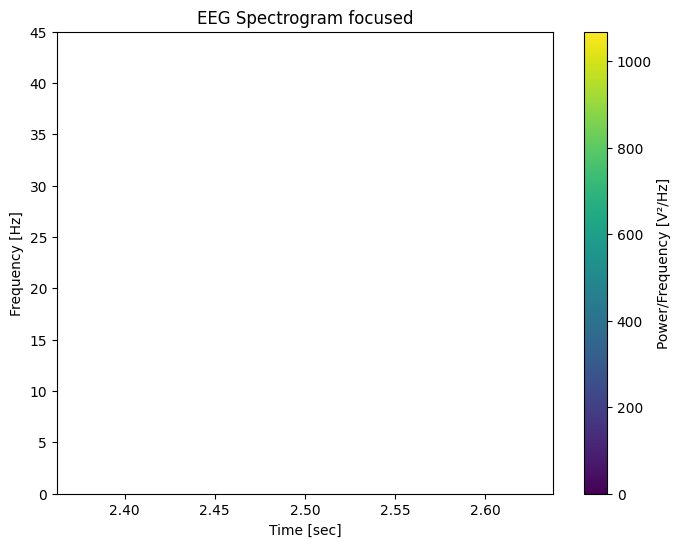

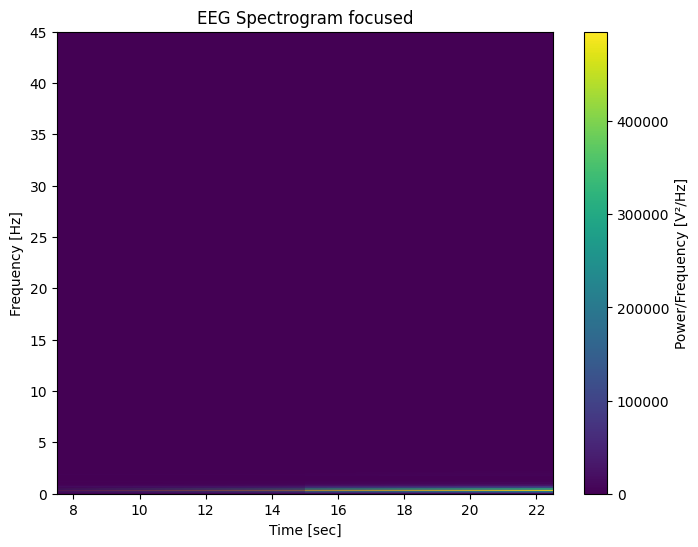

In [19]:
from scipy import signal

def create_spectogram(raw_data):
    f, t, Sxx = signal.spectrogram(
        raw_data,
        fs=128,              # Sampling rate
        nperseg=1920,         # Window size (15 second at 128 Hz)
        noverlap=0,         # 0% overlap
        nfft=1920,            # Length of FFT
        detrend='constant',  # Remove mean from each segment
        window='hann'        # Apply Hann window to reduce spectral leakage
    )
    return f, t, Sxx

def plot_spectogram(f, t, Sxx, label):
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(t, f, Sxx, shading='gouraud', cmap='viridis')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title(f'EEG Spectrogram {label}')
    plt.colorbar(label='Power/Frequency [V²/Hz]')
    plt.ylim(0, 45)  # Limit to frequencies below 45 Hz
    plt.show()


# --- first channel AF3
channel_idx = 0

raw_data = raw.get_data()[channel_idx]
f, t, Sxx = create_spectogram(raw_data)
plot_spectogram(f, t, Sxx, info["label_text"])

raw_data = raw_own.get_data()[channel_idx]
f, t, Sxx = create_spectogram(raw_data)
plot_spectogram(f, t, Sxx, info_own["label_text"])

### 4a. traditional ML models

In [68]:
# from sklearn.svm import SVC

# from sklearn.linear_model import SGDClassifier

# from sklearn.calibration import CalibratedClassifierCV

# !pip install lightgbm
# import lightgbm as lgb

# from sklearn.ensemble import GradientBoostingClassifier

from sklearn.ensemble import HistGradientBoostingClassifier

class MyModel():
    """
    combination of three binary classifiers (trained in a state vs rest manner)
    - 0: focused
    - 1: unfocused
    - 2: drowsy

    X always expects the feature vector (scaled)
    y expects an int from 0 to 2

    you HAVE to load and save manually
    - pickled objects located in MODEL_SAVE_PATH under stat_0.pkl, stat_1.pkl, stat_2.pkl
    """

    def __init__(self, verbose:bool=True, fname_body:str="stat"):
        self.classifiers = [self._spawn_classifier() for state in range(3)]
        self.verbose = verbose
        self.fname_body = fname_body

    def _spawn_classifier(self):
        # clf = SVC(
        #     kernel='linear',
        #     C=1.0,
        #     probability=True,
        #     random_state=seed
        # )

        # clf = SGDClassifier(
        #     loss='log_loss',
        #     penalty='l2',
        #     random_state=seed
        # )

        # clf = lgb.LGBMClassifier(
        #     n_estimators=100,
        #     learning_rate=0.1,
        #     max_depth=-1,
        #     num_leaves=31,
        #     random_state=seed
        # )

        # clf = GradientBoostingClassifier(n_estimators=100,learning_rate=0.1,max_depth=3,random_state=seed, warm_start=True)

        clf = HistGradientBoostingClassifier(max_iter=100,learning_rate=0.1,max_depth=3, random_state=seed, warm_start=True)

        return clf

    def load(self):
        clfs = []

        for state in range(3):
            if self.verbose: print(f"Loading {state}")

            model_path = MODEL_SAVE_PATH + f"{self.fname_body}_{state}.pkl"
            if not os.path.exists(model_path): raise FileNotFoundError(f"Model for state {state} not found at {model_path}")

            clf = joblib.load(model_path)
            clfs.append(clf)

        self.classifiers = clfs

    def save(self):
        for state in range(3):
            if self.verbose: print(f"Saving {state}")

            clf = self.classifiers[state]
            model_path = MODEL_SAVE_PATH + f"{self.fname_body}_{state}.pkl"
            joblib.dump(clf, model_path)

    def evaluate_state(self, state:int, X, y):
        clf = self.classifiers[state]
        binary_labels = (y == state).astype(int)
        accuracy = clf.score(X, binary_labels)
        return accuracy

    def evaluate(self, X, y):
        for state in range(3):
            accuracy = self.evaluate_state(state, X, y)
            print(f"State {state} classifier accuracy: {accuracy:.4f}")

    def predict(self, X):
        probs = np.zeros((X.shape[0], 3))

        for state in range(3):
            clf = self.classifiers[state]
            probs[:, state] = clf.predict_proba(X)[:, 1]

        return np.argmax(probs, axis=1)

    def train(self, X, y):
        clfs = []

        for state in range(3):
            if self.verbose: print(f"Training {state}")

            clf = self.classifiers[state]
            binary_labels = (y == state).astype(int)  # Create binary labels (state vs. rest)
            clf.fit(X, binary_labels)
            clfs.append(clf)

        self.classifiers = clfs

    def finetune(self, X, y):
        clfs = []

        for state in range(3):
            print(f"Finetuning {state}")

            clf = HistGradientBoostingClassifier(max_iter=100,learning_rate=0.1,max_depth=3, random_state=seed, warm_start=True)
            old_clf = self.classifiers[state]
            clf.set_params(
                max_iter=old_clf.max_iter+3,
                learning_rate=0.001
            )
            clf.fit(X, y)
            clfs.append(clf)

        self.classifiers = clfs

### 3b. CNN features

In [10]:
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

def process_eeg_sample(raw, sfreq, channels:list, window_size=512, overlap=0.5):
    raw = raw.pick_channels(channels)

    raw.filter(0.5, 45)
    raw.notch_filter(50)

    ch_names = raw.ch_names
    n_channels = len(ch_names)

    data = raw.get_data()


    # -- splitting
    step = int(window_size * (1 - overlap))
    n_samples = (data.shape[1] - window_size) // step + 1
    X = np.zeros((n_samples, n_channels, window_size))


    for i in range(n_samples):
        start = i * step
        end = start + window_size
        X[i] = data[:, start:end]


    # -- artifact rejection
    # peak_to_peak = np.ptp(X, axis=2)
    # valid_samples = np.all(peak_to_peak < artifact_threshold, axis=1)
    # X = X[valid_samples]
    # print(f"Rejected {np.sum(~valid_samples)} samples due to artifacts.")

    return X

def process_dataset(raw_list, info_list, sfrq, channels):
    all_features = []
    all_labels = []
    subject_ids = []

    for i, raw in tqdm(enumerate(raw_list)):
        features = process_eeg_sample(raw, sfreq, channels)

        label = info_list[i]["label"]
        subject_id = info_list[i]["subject_id"]

        labels = np.full(features.shape[0], label)
        subjects = np.full(features.shape[0], subject_id)

        all_features.append(features)
        all_labels.append(labels)
        subject_ids.append(subjects)

    X = np.vstack(all_features)
    y = np.concatenate(all_labels)
    subjects = np.concatenate(subject_ids)

    return X, y, subjects

In [11]:
print("Preprocessing data...")
X_all, y_all, subjects_all = process_dataset(raw_list, info_list, sfreq, channels)

X_test = X_all[subjects_all == 5]
y_test = y_all[subjects_all == 5]
s_test = subjects_all[subjects_all == 5]

X_rest = X_all[subjects_all != 5]
y_rest = y_all[subjects_all != 5]
s_rest = subjects_all[subjects_all != 5]

X_train, X_val, y_train, y_val, s_train, s_val = train_test_split(
    X_rest, y_rest, s_rest, test_size=0.2, random_state=seed, stratify=y_rest, shuffle=True
)

cls()

print(f"Train size: {X_train.shape[0]}, Val size: {X_val.shape[0]}, Test size: {X_test.shape[0]}")
print(f"Train label distribution: {np.unique(y_train, return_counts=True)}")
print(f"Val label distribution: {np.unique(y_val, return_counts=True)}")
print(f"Test label distribution: {np.unique(y_test, return_counts=True)}")

Train size: 14302, Val size: 3576, Test size: 3588
Train label distribution: (array([0, 1, 2]), array([4784, 4784, 4734]))
Val label distribution: (array([0, 1, 2]), array([1196, 1196, 1184]))
Test label distribution: (array([0, 1, 2]), array([1196, 1196, 1196]))


In [12]:
X_own, y_own, s_own = process_dataset(
    [focused_object, unfocused_object],
    [focused_info, unfocused_info],
    sfreq,
    channels
)

cls()

X_own.shape, y_own.shape, s_own.shape

((38, 7, 512), (38,), (38,))

In [13]:
import joblib
from sklearn.preprocessing import StandardScaler

train_shape = X_train.shape
test_shape = X_test.shape
val_shape = X_val.shape
own_shape = X_own.shape

scaler_path = os.path.join(MODEL_SAVE_PATH, "mups_scaler.pkl")

if os.path.exists(scaler_path):
    print("Loading existing scaler...")
    scaler = joblib.load(scaler_path)

    # Reshape to 2D for transformation (samples*channels, timepoints)
    X_train_2d = X_train.reshape(-1, train_shape[2])
    X_test_2d = X_test.reshape(-1, test_shape[2])
    X_val_2d = X_val.reshape(-1, val_shape[2])
    X_own_2d = X_own.reshape(-1, own_shape[2])

    # Apply transformation
    X_train_2d = scaler.transform(X_train_2d)
    X_test_2d = scaler.transform(X_test_2d)
    X_val_2d = scaler.transform(X_val_2d)
    X_own_2d = scaler.transform(X_own_2d)

else:
    print("Creating and fitting new scaler...")
    scaler = StandardScaler()

    # Reshape to 2D for fitting (samples*channels, timepoints)
    X_train_2d = X_train.reshape(-1, train_shape[2])
    X_test_2d = X_test.reshape(-1, test_shape[2])
    X_val_2d = X_val.reshape(-1, val_shape[2])
    X_own_2d = X_own.reshape(-1, own_shape[2])

    # Fit on training data only
    X_train_2d = scaler.fit_transform(X_train_2d)

    # Apply transformation to other sets
    X_test_2d = scaler.transform(X_test_2d)
    X_val_2d = scaler.transform(X_val_2d)
    X_own_2d = scaler.transform(X_own_2d)

    # Save the scaler
    joblib.dump(scaler, scaler_path)

# Reshape back to original 3D shape
X_train = X_train_2d.reshape(train_shape)
X_test = X_test_2d.reshape(test_shape)
X_val = X_val_2d.reshape(val_shape)
X_own = X_own_2d.reshape(own_shape)

Loading existing scaler...


### 4b. DL methods

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import os
import numpy as np

class EEGFeatureExtractor(nn.Module):
    """
    Feature extraction network based on EEGNet architecture
    """
    def __init__(self, num_channels, sample_length, num_filters=8, filter_size=64):
        super(EEGFeatureExtractor, self).__init__()

        # Layer 1: Temporal Convolution
        self.conv1 = nn.Conv2d(1, num_filters, (1, filter_size), padding=(0, filter_size//2), bias=False)
        self.batchnorm1 = nn.BatchNorm2d(num_filters)

        # Layer 2: Spatial Convolution (Depthwise)
        self.conv2 = nn.Conv2d(num_filters, num_filters * 2, (num_channels, 1), bias=False, groups=num_filters)
        self.batchnorm2 = nn.BatchNorm2d(num_filters * 2)
        self.activation = nn.ELU()
        self.pool1 = nn.AvgPool2d((1, 4))
        self.dropout1 = nn.Dropout(p=0.25)

        # Layer 3: Separable Convolution
        self.conv3 = nn.Conv2d(num_filters * 2, num_filters * 2, (1, 16), padding=(0, 8), bias=False, groups=num_filters * 2)
        self.conv4 = nn.Conv2d(num_filters * 2, num_filters * 2, (1, 1), bias=False)
        self.batchnorm3 = nn.BatchNorm2d(num_filters * 2)
        self.pool2 = nn.AvgPool2d((1, 8))
        self.dropout2 = nn.Dropout(p=0.25)

        # Calculate output size
        self.feature_size = num_filters * 2 * (sample_length // 32)  # After two pooling layers

    def forward(self, x):
        # Input shape: (batch_size, 1, num_channels, sample_length)

        # Layer 1
        x = self.conv1(x)
        x = self.batchnorm1(x)

        # Layer 2
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.activation(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        # Layer 3
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.batchnorm3(x)
        x = self.activation(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        # Flatten for fully connected layer
        x = x.view(x.size(0), -1)

        return x



class PredictionNetwork(nn.Module):
    """
    Prediction network with two fully connected layers
    """
    def __init__(self, input_size, num_classes, hidden_size=128):
        super(PredictionNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [20]:
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, random_split

class MyModel(nn.Module):
    def __init__(self, num_channels=7, sample_length=512, num_filters=8, filter_size=64,
                 hidden_size=128, num_classes=3, base_lr=0.001, meta_lr=0.001):
        super(MyModel, self).__init__()

        # Initialize networks
        self.feature_extractor = EEGFeatureExtractor(num_channels, sample_length, num_filters, filter_size)
        self.feature_size = self.feature_extractor.feature_size
        self.prediction_network = PredictionNetwork(self.feature_size, num_classes, hidden_size)

        # Learning rates
        self.base_lr = base_lr
        self.meta_lr = meta_lr

        # Store meta parameters separately
        self.meta_feature_params = None
        self.meta_prediction_params = None

    def save(self):
        path = MODEL_SAVE_PATH + "/mups.pth"
        torch.save({
            'feature_extractor': self.feature_extractor.state_dict(),
            'prediction_network': self.prediction_network.state_dict(),
            'meta_feature_params': self.meta_feature_params,
            'meta_prediction_params': self.meta_prediction_params
        }, path)

        print(f"Model saved to {path}")

    def load(self):
        path = MODEL_SAVE_PATH + "/mups.pth"
        checkpoint = torch.load(path, map_location=torch.device('cpu'))

        # Load weights
        self.feature_extractor.load_state_dict(checkpoint['feature_extractor'])
        self.prediction_network.load_state_dict(checkpoint['prediction_network'])

        # Load meta parameters if they exist
        if 'meta_feature_params' in checkpoint and checkpoint['meta_feature_params'] is not None:
            self.meta_feature_params = checkpoint['meta_feature_params']

        if 'meta_prediction_params' in checkpoint and checkpoint['meta_prediction_params'] is not None:
            self.meta_prediction_params = checkpoint['meta_prediction_params']

        print(f"Model loaded from {path}")

    def forward(self, x):
        # Ensure input has the right shape (add channel dimension if needed)
        if len(x.shape) == 3:  # [batch, channels, time]
            x = x.unsqueeze(1)  # [batch, 1, channels, time]

        features = self.feature_extractor(x)
        output = self.prediction_network(features)
        return output

    def save_meta_params(self):
        """Save current parameters as meta parameters"""
        self.meta_feature_params = [p.clone().detach() for p in self.feature_extractor.parameters()]
        self.meta_prediction_params = [p.clone().detach() for p in self.prediction_network.parameters()]

    def load_meta_params(self):
        """Load saved meta parameters back to the model"""
        if self.meta_feature_params is not None and self.meta_prediction_params is not None:
            for p_model, p_meta in zip(self.feature_extractor.parameters(), self.meta_feature_params):
                p_model.data.copy_(p_meta.data)
            for p_model, p_meta in zip(self.prediction_network.parameters(), self.meta_prediction_params):
                p_model.data.copy_(p_meta.data)

    def pretrain_feature_extractor(self, X, y, epochs=10, batch_size=32, val_split=0.2):
        """Pretrain the feature extractor on all source data"""
        print("Pretraining feature extractor...")

        # Prepare data
        X_tensor = torch.FloatTensor(X).unsqueeze(1)  # Add channel dimension
        y_tensor = torch.LongTensor(y)
        dataset = TensorDataset(X_tensor, y_tensor)

        # Split into train/val
        val_size = int(len(dataset) * val_split)
        train_size = len(dataset) - val_size
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        # Create a temporary prediction head for pretraining
        temp_head = PredictionNetwork(self.feature_size, len(np.unique(y)), hidden_size=128)
        optimizer = optim.SGD(list(self.feature_extractor.parameters()) +
                             list(temp_head.parameters()), lr=0.01)
        criterion = nn.CrossEntropyLoss()

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.feature_extractor.to(device)
        temp_head.to(device)

        best_val_acc = 0

        for epoch in range(epochs):
            # Training
            self.feature_extractor.train()
            temp_head.train()
            train_loss = 0
            correct = 0
            total = 0

            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                optimizer.zero_grad()
                features = self.feature_extractor(inputs)
                outputs = temp_head(features)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

            train_acc = 100 * correct / total

            # Validation
            self.feature_extractor.eval()
            temp_head.eval()
            val_loss = 0
            correct = 0
            total = 0

            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)

                    features = self.feature_extractor(inputs)
                    outputs = temp_head(features)
                    loss = criterion(outputs, targets)

                    val_loss += loss.item()
                    _, predicted = outputs.max(1)
                    total += targets.size(0)
                    correct += predicted.eq(targets).sum().item()

            val_acc = 100 * correct / total

            print(f"Epoch {epoch+1}/{epochs}: Train Loss: {train_loss/len(train_loader):.4f}, "
                  f"Train Acc: {train_acc:.2f}%, Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%")

            # Save best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                # We don't need to save temp_head

        print(f"Pretraining complete. Best validation accuracy: {best_val_acc:.2f}%")

        # Initialize meta parameters after pretraining
        self.save_meta_params()

        return self.feature_extractor

    def create_meta_tasks(self, X, y, subjects, num_tasks=12, samples_per_task=20, subjects_per_task=None):
        """Create meta-tasks from source data"""
        unique_subjects = np.unique(subjects)
        num_subjects = len(unique_subjects)

        if subjects_per_task is None:
            subjects_per_task = max(2, num_subjects // 2)  # Use half the subjects by default

        meta_tasks = []

        for _ in range(num_tasks):
            # Select random subjects for this task
            task_subjects = np.random.choice(unique_subjects, subjects_per_task, replace=False)

            # Get indices for these subjects
            task_indices = np.where(np.isin(subjects, task_subjects))[0]

            # If we have enough samples, randomly select samples_per_task
            if len(task_indices) >= samples_per_task:
                selected_indices = np.random.choice(task_indices, samples_per_task, replace=False)

                # Split into base and meta sets (50/50)
                base_indices = selected_indices[:samples_per_task//2]
                meta_indices = selected_indices[samples_per_task//2:]

                meta_tasks.append({
                    'base': (X[base_indices], y[base_indices]),
                    'meta': (X[meta_indices], y[meta_indices])
                })

        return meta_tasks

    def fit(self, X, y, subjects, epochs=20, num_tasks=12, samples_per_task=20,
              base_updates=10, pretrain=True):
        """Full training process including pretraining and meta-training"""
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)

        # Step 1: Pretrain feature extractor if requested
        if pretrain:
            self.pretrain_feature_extractor(X, y, epochs=10)

        # Step 2: Meta-training
        print("Starting meta-training...")

        # Initialize optimizers
        meta_optimizer = optim.Adam([
            {'params': self.feature_extractor.parameters()},
            {'params': self.prediction_network.parameters()}
        ], lr=self.meta_lr)

        criterion = nn.CrossEntropyLoss()

        # Learning rate scheduler
        scheduler = optim.lr_scheduler.StepLR(meta_optimizer, step_size=5, gamma=0.2)

        for epoch in range(epochs):
            # Create meta tasks for this epoch
            meta_tasks = self.create_meta_tasks(X, y, subjects, num_tasks, samples_per_task)

            meta_loss = 0
            meta_correct = 0
            meta_total = 0

            for task_idx, task in enumerate(meta_tasks):
                # Get base and meta data for this task
                X_base, y_base = task['base']
                X_meta, y_meta = task['meta']

                # Convert to tensors and move to device
                X_base = torch.FloatTensor(X_base).unsqueeze(1).to(device)
                y_base = torch.LongTensor(y_base).to(device)
                X_meta = torch.FloatTensor(X_meta).unsqueeze(1).to(device)
                y_meta = torch.LongTensor(y_meta).to(device)

                # Save current meta parameters
                self.save_meta_params()

                # Base learning phase (inner loop) - only update prediction network
                base_optimizer = optim.Adam(self.prediction_network.parameters(), lr=self.base_lr)

                for _ in range(base_updates):
                    # Forward pass
                    features = self.feature_extractor(X_base)
                    outputs = self.prediction_network(features)
                    loss = criterion(outputs, y_base)

                    # Backward and optimize
                    base_optimizer.zero_grad()
                    loss.backward()
                    base_optimizer.step()

                # Meta learning phase (outer loop)
                # Evaluate on meta set
                features = self.feature_extractor(X_meta)
                outputs = self.prediction_network(features)
                loss = criterion(outputs, y_meta)

                # Compute metrics
                meta_loss += loss.item()
                _, predicted = outputs.max(1)
                meta_total += y_meta.size(0)
                meta_correct += predicted.eq(y_meta).sum().item()

                # Load back meta parameters
                self.load_meta_params()

                # Update meta parameters
                meta_optimizer.zero_grad()
                loss.backward()
                meta_optimizer.step()

                # Save updated parameters as new meta parameters
                self.save_meta_params()

            # Update learning rate
            scheduler.step()

            # Print epoch statistics
            meta_acc = 100 * meta_correct / meta_total if meta_total > 0 else 0
            print(f"Epoch {epoch+1}/{epochs}: Meta Loss: {meta_loss/len(meta_tasks):.4f}, "
                  f"Meta Accuracy: {meta_acc:.2f}%")

        print("Meta-training complete!")
        return self

    def finetune(self, X_target, y_target, epochs=5, batch_size=16):
        """Finetune the model on target subject data"""
        print("Finetuning on target subject...")

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)

        # Prepare data
        X_tensor = torch.FloatTensor(X_target).unsqueeze(1).to(device)  # Add channel dimension
        y_tensor = torch.LongTensor(y_target).to(device)
        dataset = TensorDataset(X_tensor, y_tensor)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        # Only update prediction network during finetuning
        optimizer = optim.Adam(self.prediction_network.parameters(), lr=self.base_lr)
        criterion = nn.CrossEntropyLoss()

        # Freeze feature extractor
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

        for epoch in range(epochs):
            self.train()
            train_loss = 0
            correct = 0
            total = 0

            for inputs, targets in loader:
                optimizer.zero_grad()

                # Forward pass
                outputs = self(inputs)
                loss = criterion(outputs, targets)

                # Backward and optimize
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

            train_acc = 100 * correct / total
            print(f"Finetune Epoch {epoch+1}/{epochs}: Loss: {train_loss/len(loader):.4f}, "
                  f"Accuracy: {train_acc:.2f}%")

        # Unfreeze feature extractor for future use
        for param in self.feature_extractor.parameters():
            param.requires_grad = True

        print("Finetuning complete!")
        return self

    def score(self, X, y, batch_size=32):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        self.eval()  # Set model to evaluation mode

        # Convert data to tensors
        X_tensor = torch.FloatTensor(X)
        if len(X_tensor.shape) == 3:  # If shape is [samples, channels, time]
            X_tensor = X_tensor.unsqueeze(1)  # Add channel dimension [samples, 1, channels, time]

        y_tensor = torch.LongTensor(y)
        dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
        loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

        correct = 0
        total = 0

        with torch.no_grad():  # No gradient calculation needed
            for inputs, targets in loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = self(inputs)
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        # Return to training mode
        self.train()

        # Return accuracy as a fraction (0.0 to 1.0)
        return correct / total if total > 0 else 0.0

### 5. training and evaluation

In [15]:
X_train.shape, y_train.shape, s_train.shape

((14302, 7, 512), (14302,), (14302,))

In [ ]:
# model = MyModel()

# model.train(X_train, y_train)

# model.evaluate(X_train[:7000], y_train[:7000]) # Evaluate on train subset - 7000 is the size of val and test
# model.evaluate(X_val, y_val) # Evaluate on val set (intra-subject)
# model.evaluate(X_test, y_test) # evaluate on test set (extra-subject)
# model.evaluate(X_own, y_own) # evaluate on own set (extra-subject & extra-device with "shitty" recording)

In [22]:
model = MyModel()


model.fit(X_train[:7000], y_train[:7000], s_train[:7000])

# MUPS train is only the meta-training, it should take just a few seconds
model.finetune(X_test[:80], y_test[:80])
print(model.score(X_test[80:], y_test[80:]))

model.save()

Pretraining feature extractor...
Epoch 1/10: Train Loss: 1.1112, Train Acc: 33.14%, Val Loss: 1.0972, Val Acc: 35.07%
Epoch 2/10: Train Loss: 1.1008, Train Acc: 34.82%, Val Loss: 1.0937, Val Acc: 37.93%
Epoch 3/10: Train Loss: 1.0928, Train Acc: 36.75%, Val Loss: 1.0891, Val Acc: 42.86%
Epoch 4/10: Train Loss: 1.0832, Train Acc: 39.79%, Val Loss: 1.0708, Val Acc: 48.07%
Epoch 5/10: Train Loss: 1.0622, Train Acc: 43.80%, Val Loss: 1.0341, Val Acc: 51.86%
Epoch 6/10: Train Loss: 1.0218, Train Acc: 47.62%, Val Loss: 0.9988, Val Acc: 52.86%
Epoch 7/10: Train Loss: 0.9979, Train Acc: 49.59%, Val Loss: 0.9628, Val Acc: 54.50%
Epoch 8/10: Train Loss: 0.9886, Train Acc: 50.39%, Val Loss: 0.9753, Val Acc: 54.00%
Epoch 9/10: Train Loss: 0.9666, Train Acc: 51.59%, Val Loss: 0.9513, Val Acc: 54.57%
Epoch 10/10: Train Loss: 0.9578, Train Acc: 52.41%, Val Loss: 0.9523, Val Acc: 56.57%
Pretraining complete. Best validation accuracy: 56.57%
Starting meta-training...
Epoch 1/20: Meta Loss: 1.0423, Meta

##### indepth model eval

In [21]:
### testing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def evaluate_model(model, X, y):
    """
    X must be scaled already, this is how pred expects it
    """
    preds = model.predict(X)

    # overall performance
    accuracy = accuracy_score(y, preds)
    precision = precision_score(y, preds, average='weighted')
    recall = recall_score(y, preds, average='weighted')
    f1 = f1_score(y, preds, average='weighted')

    class_report = classification_report(y, preds, output_dict=True)

    print(f"Model Evaluation Results:")
    print(f"-------------------------")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    # print("\nClassification Report:")
    # print(class_report)


    # confusion matrix
    cm = confusion_matrix(y, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Focused', 'Unfocused', 'Drowsy'],
                yticklabels=['Focused', 'Unfocused', 'Drowsy'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


    # class-specific performance
    class_metrics = {}
    class_keys = [k for k in class_report.keys() if k in ['0', '1', '2']]
    for key in class_keys:
        class_metrics[int(key)] = { # Convert key back to int for dict key if preferred
            'precision': class_report[key]['precision'],
            'recall': class_report[key]['recall'],
            'f1-score': class_report[key]['f1-score']
        }

    # Create DataFrame from class_metrics and transpose
    metrics_df = pd.DataFrame(class_metrics).T

    # Map the numeric index to meaningful labels if the class is present
    label_map = {0: 'Focused', 1: 'Unfocused', 2: 'Drowsy'}
    # Create a new index based on the keys of the metrics_df index
    metrics_df.index = [label_map[idx] for idx in metrics_df.index]


    plt.figure(figsize=(10, 6))
    metrics_df.plot(kind='bar')
    plt.title('Per-class Performance Metrics')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()


    #
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'class_report': class_report
    }

    return metrics

In [ ]:
X = X_test[:-1]
y = y_test[:-1]
metrics = evaluate_model(model, X, y)

### 6. finetuning on test-set

In [58]:
# --- decide whichever data-split you want to finetune on
X_finetune = X_own
y_finetune = y_own

X_finetune_train, X_finetune_val, y_finetune_train, y_finetune_val = train_test_split(
    X_finetune, y_finetune, test_size=0.1, random_state=seed, stratify=y_own
)

##### finetuning loop

In [71]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

current_samples = 0

# --- weird splitting strategy
batch_size = 10 # was 60 but own set too short
n_batches = len(X_finetune_train) // batch_size

if len(X_finetune_train) <= batch_size / 2:
    raise ValueError("set must have at least two batches in them")

skf = StratifiedKFold(n_splits=n_batches, shuffle=True, random_state=seed)


# --- Training loop
for i, indexes in enumerate(skf.split(X_finetune_train, y_finetune_train)):
    batch_index = indexes[1]

    X = X_finetune_train[batch_index]
    y = y_finetune_train[batch_index]

    current_samples = (i+1) * batch_size

    start = time.time()
    model.finetune(X, y)
    model.save()
    print(f"--- after {current_samples} samples (thus {current_samples+14} seconds) (actual training took {time.time() - start} seconds) ---")
    model.evaluate(X_finetune_val, y_finetune_val)




Finetuning 0
Finetuning 1
Finetuning 2
Saving 0
Saving 1
Saving 2
--- after 10 samples (thus 24 seconds) (actual training took 0.2087721824645996 seconds) ---
State 0 classifier accuracy: 0.5000
State 1 classifier accuracy: 0.5000
State 2 classifier accuracy: 1.0000
Finetuning 0
Finetuning 1
Finetuning 2
Saving 0
Saving 1
Saving 2
--- after 20 samples (thus 34 seconds) (actual training took 0.5717630386352539 seconds) ---
State 0 classifier accuracy: 0.5000
State 1 classifier accuracy: 0.5000
State 2 classifier accuracy: 1.0000
Finetuning 0
Finetuning 1
Finetuning 2
Saving 0
Saving 1
Saving 2
--- after 30 samples (thus 44 seconds) (actual training took 0.22838544845581055 seconds) ---
State 0 classifier accuracy: 0.5000
State 1 classifier accuracy: 0.5000
State 2 classifier accuracy: 0.0000
Finetuning 0
Finetuning 1
Finetuning 2
Saving 0
Saving 1
Saving 2
--- after 40 samples (thus 54 seconds) (actual training took 0.23259615898132324 seconds) ---
State 0 classifier accuracy: 0.5000
St

In [57]:
# --- plotting how accuracies went up or down over training TODO

### 7b model export to onnx